## Module 1

In [49]:
import requests
from collections import Counter
import pandas as pd
import plotly.express as px

In [50]:
url = 'https://graphql.anilist.co'

In [51]:
def find_data(year):
    query = """
    query ($year: Int, $page: Int, $perPage: Int) {
    Page(page: $page, perPage: $perPage) {
        media(seasonYear: $year, type: ANIME, sort: POPULARITY_DESC) {
        id
        title {
            romaji
            english
        }
        genres
        season
        seasonYear
        averageScore
        }
    }
    }
    """

    variables = {
        'year': year,
        'page': 1,
        'perPage': 50
    }

    response = requests.post(url, json={'query': query, 'variables': variables})
    data = response.json()
    
    data_clean = data['data']['Page']['media']
    df = pd.json_normalize(data_clean)
    
    # print(df['title.english'])
    
    genres = [genre for sublist in df['genres'] for genre in sublist]
    # when most_common > is around 10, we get an error, should inplement a dropna somwhere
    genre_counter = Counter(genres).most_common(5)
    top_genres = pd.DataFrame(genre_counter, columns=['Genre', 'Count'])
    
    # should return the database, not some strings.
    # return top_genres.to_string(index=False)
    return top_genres

In [52]:
# finding most popular genres from range
for i in range(26):
    year_index = i + 2000
    x = find_data(year_index)
    print(f'{year_index} Anime: \n{x}\n')

2000 Anime: 
       Genre  Count
0     Comedy     21
1     Action     20
2  Adventure     18
3    Fantasy     18
4      Drama     18

2001 Anime: 
       Genre  Count
0     Comedy     27
1     Action     26
2      Drama     23
3  Adventure     17
4     Sci-Fi     17

2002 Anime: 
       Genre  Count
0     Comedy     27
1      Drama     24
2     Sci-Fi     23
3     Action     22
4  Adventure     22

2003 Anime: 
       Genre  Count
0     Comedy     26
1      Drama     24
2  Adventure     23
3     Action     22
4     Sci-Fi     16

2004 Anime: 
     Genre  Count
0    Drama     27
1   Comedy     27
2   Action     24
3  Romance     17
4   Sci-Fi     16

2005 Anime: 
          Genre  Count
0         Drama     27
1        Comedy     24
2        Action     21
3       Romance     20
4  Supernatural     16

2006 Anime: 
          Genre  Count
0        Action     23
1         Drama     21
2        Comedy     20
3       Romance     17
4  Supernatural     15

2007 Anime: 
     Genre  Count
0   Act

TypeError: 'NoneType' object is not subscriptable

In [55]:
def create_visual(start_date, end_date):
    data_collection = []
    years_range = []
    for i in range(start_date, end_date):
        years_range.append(i)
    for j in years_range:
        df_year = find_data(j)
        df_year['Year'] = j
        data_collection.append(df_year)
        
    total_data = pd.concat(data_collection, ignore_index=True)
    
    fig = px.line(
        total_data, 
        x='Year', 
        y='Count', 
        color='Genre',  
        markers=True,   
        title='Anime Genre Popularity Over Years'
    )
    fig.update_layout(
        xaxis_title='Year',
        yaxis_title='Count',
        legend_title='Genre',
        hovermode='x unified' 
    )
    fig.write_html("anime_genre_trends.html", auto_open=True)

In [56]:
# run function
create_visual(2021, 2025)

---

## Module 2

In [57]:
import requests
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [102]:
url = 'https://graphql.anilist.co'

In [103]:

def get_anime_data(year=2020, limit=50):
    query = """
    query ($year: Int, $page: Int, $perPage: Int) {
      Page(page: $page, perPage: $perPage) {
        media(seasonYear: $year, type: ANIME, sort: POPULARITY_DESC) {
          id
          title {
            romaji
            english
          }
          genres
          averageScore
        }
      }
    }
    """

    variables = {
        'year': year,
        'page': 1,
        'perPage': limit
    }

    response = requests.post(url, json={'query': query, 'variables': variables})
    response.raise_for_status()

    anime = response.json()['data']['Page']['media']

    cleaned = []
    for a in anime:
        title = a['title']['english'] or a['title']['romaji']
        if title and a['genres']:
            cleaned.append({
                "id": a['id'],
                "title": title,
                "genres": a['genres'],
                "score": a['averageScore'] or 0
            })

    return cleaned

In [ ]:
# similarity/collaborators section 

def jaccard_similarity(g1, g2):
    s1, s2 = set(g1), set(g2)
    return len(s1 & s2) / len(s1 | s2)


def get_anime_similarities(anime_list, threshold=0.6):
    similarities = []

    for i in range(len(anime_list)):
        for j in range(i + 1, len(anime_list)):
            a1, a2 = anime_list[i], anime_list[j]
            sim = jaccard_similarity(a1['genres'], a2['genres'])

            if sim >= threshold:
                similarities.append(
                    (a1['id'], a2['id'], sim)
                )

    return similarities

In [ ]:
# cleaning

def get_anime_name(anime_id, anime_lookup):
    return anime_lookup.get(anime_id, str(anime_id))


def map_ids_to_names(df, anime_lookup):
    df['anime_name'] = df['anime_id'].map(anime_lookup)
    return df

In [ ]:
# central node

anime_list = get_anime_data(year=2020, limit=50)
anime_lookup = {a['id']: a['title'] for a in anime_list}

similarities = get_anime_similarities(anime_list)

In [ ]:
# graphing

G = nx.Graph()

for a1, a2, sim in similarities:
    if G.has_edge(a1, a2):
        G[a1][a2]['weight'] += sim
    else:
        G.add_edge(a1, a2, weight=sim)

In [ ]:
# importance

degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
weighted_degree = dict(G.degree(weight='weight'))

df = pd.DataFrame({
    'anime_id': list(G.nodes()),
    'degree_centrality': [degree_centrality[n] for n in G.nodes()],
    'betweenness_centrality': [betweenness_centrality[n] for n in G.nodes()],
    'weighted_degree': [weighted_degree[n] for n in G.nodes()]
})

df = map_ids_to_names(df, anime_lookup)

In [ ]:
# top 5
top_anime = df.sort_values('degree_centrality', ascending=False).head(5)
print(top_anime[['anime_name', 'degree_centrality',
                 'betweenness_centrality', 'weighted_degree']])


                                           anime_name  degree_centrality  \
7               My Teen Romantic Comedy SNAFU Climax!              0.200   
28  Is It Wrong to Try to Pick Up Girls in a Dunge...              0.175   
29  BOFURI: I Don't Want to Get Hurt, so I'll Max ...              0.175   
6                     TONIKAWA: Over The Moon For You              0.150   
15                     GOBLIN SLAYER -GOBLIN’S CROWN-              0.150   

    betweenness_centrality  weighted_degree  
7                 0.088034         5.466667  
28                0.054915         4.380952  
29                0.218590         4.266667  
6                 0.191239         4.333333  
15                0.050385         4.133333  


In [ ]:
# edge table

edge_data = [
    {
        "anime1": get_anime_name(a1, anime_lookup),
        "anime2": get_anime_name(a2, anime_lookup),
        "similarity": data['weight']
    }
    for a1, a2, data in G.edges(data=True)
]

df_edges = pd.DataFrame(edge_data)
print(df_edges.head())

                                              anime1  \
0                                     JUJUTSU KAISEN   
1                                     JUJUTSU KAISEN   
2                                Fire Force Season 2   
3                                Fire Force Season 2   
4  Demon Slayer -Kimetsu no Yaiba- The Movie: Mug...   

                                            anime2  similarity  
0                              Fire Force Season 2    0.750000  
1                          Toilet-bound Hanako-kun    0.600000  
2                                    Akudama Drive    0.600000  
3  The Irregular at Magic High School: Visitor Arc    0.600000  
4                                     Tower of God    0.833333  


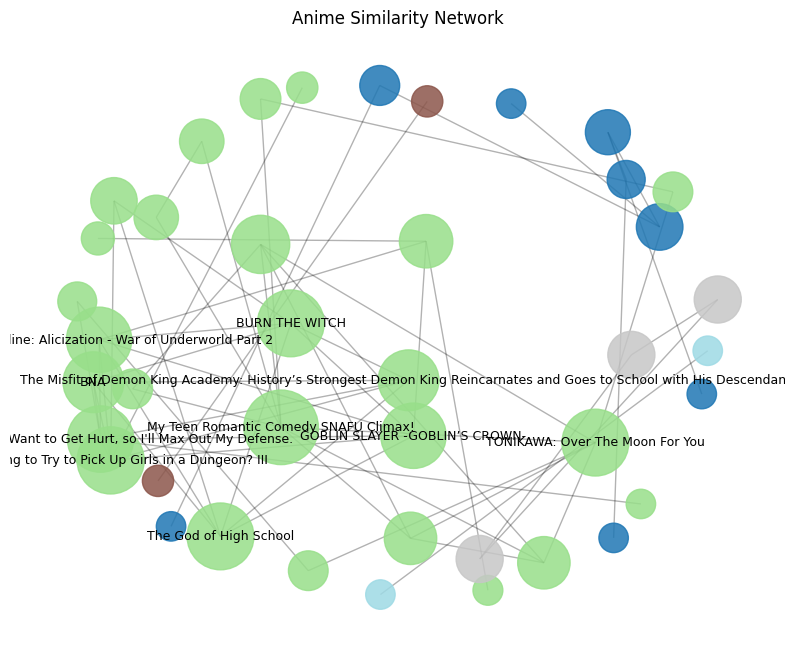

In [ ]:
# visualz

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42, k=1.5)

components = list(nx.connected_components(G))
node_colors = {}

for i, comp in enumerate(components):
    for node in comp:
        node_colors[node] = i

colors = [node_colors[n] for n in G.nodes()]


nx.draw_networkx_nodes(
    G, pos,
    node_size=[150 + 500 * weighted_degree[n] for n in G.nodes()],
    node_color=colors,
    cmap=plt.cm.tab20,
    alpha=0.85
)


nx.draw_networkx_edges(G, pos, alpha=0.3)

top_nodes = sorted(weighted_degree, key=weighted_degree.get, reverse=True)[:10]

labels = {n: get_anime_name(n, anime_lookup) for n in top_nodes}

nx.draw_networkx_labels(G, pos, labels, font_size=9)


plt.title('Anime Similarity Network')
plt.axis('off')
plt.show()


---

## Module 3

In [65]:
import requests
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.metrics import DistanceMetric
from sklearn.metrics.pairwise import cosine_similarity

In [66]:
url = 'https://graphql.anilist.co'

In [67]:
def find_data(year):
    query = """
    query ($year: Int, $page: Int, $perPage: Int) {
      Page(page: $page, perPage: $perPage) {
        media(seasonYear: $year, type: ANIME, sort: POPULARITY_DESC) {
          id
          title {
            romaji
            english
          }
          genres
          season
          seasonYear
          averageScore
          episodes
          popularity
        }
      }
    }
    """

    variables = {
        'year': year,
        'page': 1,
        'perPage': 50
    }

    response = requests.post(url, json={'query': query, 'variables': variables})
    data = response.json()
    anime_data = data['data']['Page']['media']

    df = pd.json_normalize(anime_data)

    # Keep useful columns
    df = df[['title.romaji', 'title.english', 'genres', 'season', 'seasonYear', 'popularity','averageScore']]
    df = df.dropna(subset=['genres'])  # Remove entries without genre data

    # Create a simplified title column
    df['title'] = df['title.english'].fillna(df['title.romaji'])
    df = df.dropna(subset=['title']).reset_index(drop=True)

    # Normalize score (optional)
    df['averageScore'] = df['averageScore'].fillna(df['averageScore'].mean())
    df['score_norm'] = (df['averageScore'] - df['averageScore'].min()) / (df['averageScore'].max() - df['averageScore'].min())

    return df

In [77]:
def get_anime_data_range(start_year, end_year):
    all_years = []
    for y in range(start_year, end_year + 1):
        try:
            year_df = find_data(y)
            all_years.append(year_df)
        except Exception as e:
            print(f"Error fetching {y}: {e}")
    combined_df = pd.concat(all_years, ignore_index=True)
    return combined_df

In [84]:
# test
# df = find_data(2025)
# df.head(15)
# anime_df = get_anime_data_range(2018, 2024)
anime_df = get_anime_data_range(2005, 2025)
anime_df.sort_values(by='popularity', ascending=False).head(50)

,title.romaji,title.english,genres,season,seasonYear,popularity,averageScore,title,score_norm
400,Shingeki no Kyojin,Attack on Titan,"[Action, Drama, Fantasy, Mystery]",SPRING,2013,927669,85,Attack on Titan,0.930233
700,Kimetsu no Yaiba,Demon Slayer: Kimetsu no Yaiba,"[Action, Adventure, Drama, Fantasy, Supernatural]",SPRING,2019,880849,82,Demon Slayer: Kimetsu no Yaiba,0.781250
50,DEATH NOTE,Death Note,"[Mystery, Psychological, Supernatural, Thriller]",FALL,2006,844674,84,Death Note,0.980769
750,Jujutsu Kaisen,JUJUTSU KAISEN,"[Action, Drama, Supernatural]",FALL,2020,836122,84,JUJUTSU KAISEN,0.875000
550,Boku no Hero Academia,My Hero Academia,"[Action, Adventure, Comedy]",SPRING,2016,781300,76,My Hero Academia,0.538462
300,HUNTER×HUNTER (2011),Hunter x Hunter (2011),"[Action, Adventure, Fantasy]",FALL,2011,746422,89,Hunter x Hunter (2011),1.000000
500,One Punch Man,One-Punch Man,"[Action, Comedy, Sci-Fi, Supernatural]",FALL,2015,692635,83,One-Punch Man,0.741935
450,Tokyo Ghoul,Tokyo Ghoul,"[Action, Drama, Horror, Mystery, Psychological...",SUMMER,2014,661070,76,Tokyo Ghoul,0.550000
600,Shingeki no Kyojin Season 2,Attack on Titan Season 2,"[Action, Drama, Fantasy, Mystery]",SPRING,2017,653893,84,Attack on Titan Season 2,0.848485
200,Hagane no Renkinjutsushi: FULLMETAL ALCHEMIST,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy]",SPRING,2009,644686,90,Fullmetal Alchemist: Brotherhood,1.000000


In [70]:
# jaccard similarity
def jaccard_similarity(genres1, genres2):
    set1, set2 = set(genres1), set(genres2)
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union > 0 else 0

In [71]:
# get similarity 
def compute_similarity(df, weight_genre=0.8, weight_score=0.2):
    n = len(df)
    sim_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            genre_sim = jaccard_similarity(df['genres'][i], df['genres'][j])
            score_sim = 1 - abs(df['score_norm'][i] - df['score_norm'][j])  
            sim_matrix[i, j] = (weight_genre * genre_sim) + (weight_score * score_sim)
    return sim_matrix

In [72]:
# get similiarty
def top_similar(df, sim_matrix, title, n=10):
    if title not in df['title'].values:
        print(f"'{title}' not found in dataset.")
        return

    idx = df.index[df['title'] == title][0]
    similar_indices = sim_matrix[idx].argsort()[::-1][1:n+1]  
    result = df.iloc[similar_indices][['title', 'genres', 'score_norm']]
    return result

In [78]:
anime_df = get_anime_data_range(2020, 2025)
df = anime_df
sim_matrix = compute_similarity(df)

In [100]:
queries = ['JUJUTSU KAISEN', 'SPY x FAMILY', 'Mob Psycho 100 III']

In [91]:
anime = queries[0]
print(anime)
top_similar(df, sim_matrix, anime).sort_values(by='score_norm', ascending=False)

JUJUTSU KAISEN


,title,genres,score_norm
150,JUJUTSU KAISEN Season 2,"[Action, Drama, Supernatural]",0.857143
55,JUJUTSU KAISEN 0,"[Action, Supernatural]",0.842105
100,Chainsaw Man,"[Action, Drama, Horror, Supernatural]",0.777778
74,JoJo's Bizarre Adventure: STONE OCEAN,"[Action, Adventure, Drama, Supernatural]",0.763158
133,JoJo's Bizarre Adventure: STONE OCEAN Part 2,"[Action, Adventure, Drama, Supernatural]",0.740741
52,Tokyo Revengers,"[Action, Drama, Romance, Supernatural]",0.657895
261,Fire Force Season 3,"[Action, Drama, Sci-Fi, Supernatural]",0.647059
8,Fire Force Season 2,"[Action, Drama, Sci-Fi, Supernatural]",0.625000
97,Kemono Jihen,"[Action, Drama, Mystery, Supernatural]",0.552632
173,Tokyo Revengers Season 2,"[Action, Drama, Romance, Supernatural]",0.428571


In [96]:
anime = queries[1]
print(anime)
top_similar(df, sim_matrix, anime).sort_values(by='score_norm', ascending=False)

SPY x FAMILY


,title,genres,score_norm
111,Mob Psycho 100 III,"[Action, Comedy, Drama, Psychological, Slice o...",0.925926
187,Bungo Stray Dogs 4,"[Action, Comedy, Mystery, Supernatural]",0.750000
266,SPY x FAMILY Season 3,"[Action, Comedy, Slice of Life, Supernatural]",0.735294
106,SPY x FAMILY Cour 2,"[Action, Comedy, Slice of Life, Supernatural]",0.703704
193,SPY x FAMILY CODE: White,"[Action, Adventure, Comedy, Slice of Life, Sup...",0.642857
161,SPY x FAMILY Season 2,"[Action, Comedy, Slice of Life, Supernatural]",0.607143
182,Buddy Daddies,"[Action, Comedy, Drama, Slice of Life]",0.607143
80,Mieruko-chan,"[Comedy, Horror, Slice of Life, Supernatural]",0.552632
160,Zom 100: Bucket List of the Dead,"[Action, Comedy, Horror, Supernatural]",0.500000
181,Undead Unluck,"[Action, Comedy, Sci-Fi, Supernatural]",0.500000


In [101]:
anime = queries[2]
print(anime)
top_similar(df, sim_matrix, anime).sort_values(by='score_norm', ascending=False)

Mob Psycho 100 III


,title,genres,score_norm
77,Fruits Basket The Final Season,"[Comedy, Drama, Psychological, Romance, Slice ...",1.000000
18,Fruits Basket Season 2,"[Comedy, Drama, Psychological, Romance, Slice ...",0.916667
41,Fate/stay night [Heaven’s Feel] III. spring song,"[Action, Drama, Fantasy, Psychological, Supern...",0.916667
271,Call of the Night Season 2,"[Comedy, Psychological, Romance, Slice of Life...",0.794118
101,SPY x FAMILY,"[Action, Comedy, Slice of Life, Supernatural]",0.777778
266,SPY x FAMILY Season 3,"[Action, Comedy, Slice of Life, Supernatural]",0.735294
106,SPY x FAMILY Cour 2,"[Action, Comedy, Slice of Life, Supernatural]",0.703704
193,SPY x FAMILY CODE: White,"[Action, Adventure, Comedy, Slice of Life, Sup...",0.642857
161,SPY x FAMILY Season 2,"[Action, Comedy, Slice of Life, Supernatural]",0.607143
182,Buddy Daddies,"[Action, Comedy, Drama, Slice of Life]",0.607143
